
# Predict Employee Churn with Decision Trees and Random Forests

## Import Libraries

In [98]:
#!pip install graphviz


In [99]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
#import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [100]:
plt.rcParams['figure.figsize'] = (12,8)

## Exploratory Data Analysis

In [101]:
hr = pd.read_csv("C:/Users/vidus/Documents/Projects/Employee Turnover/employee_data.csv")
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [102]:
#hr.profile_report(title="Data Report")

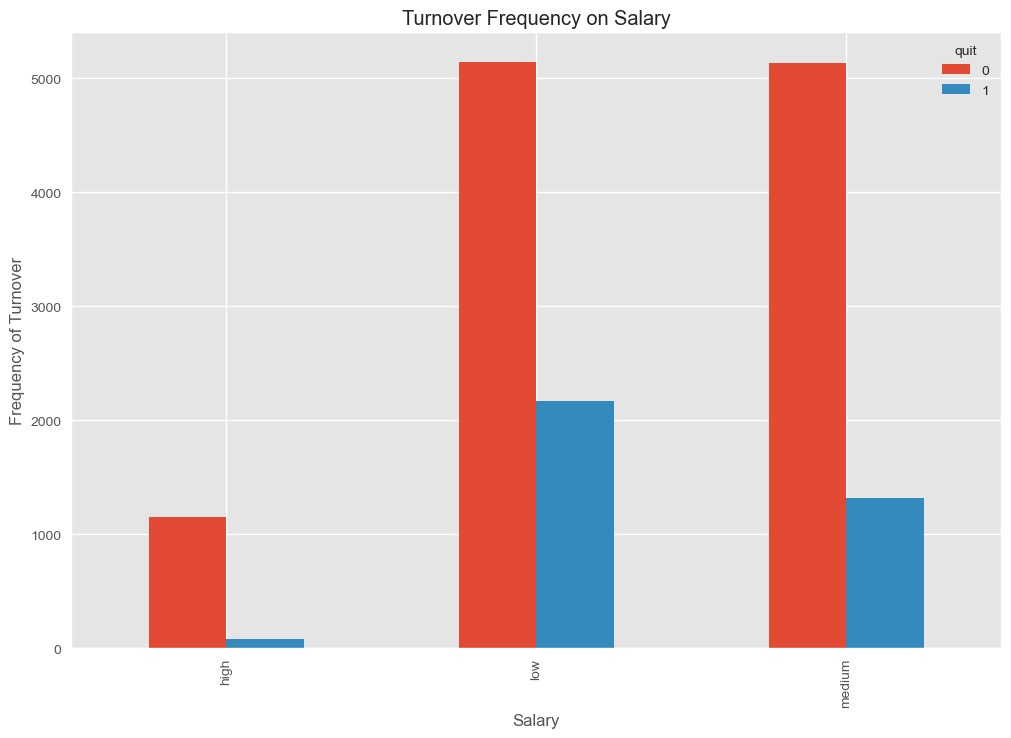

In [103]:
pd.crosstab(hr.salary, hr.quit).plot(kind="bar")
plt.title("Turnover Frequency on Salary")
plt.xlabel("Salary")
plt.ylabel("Frequency of Turnover")
plt.show()

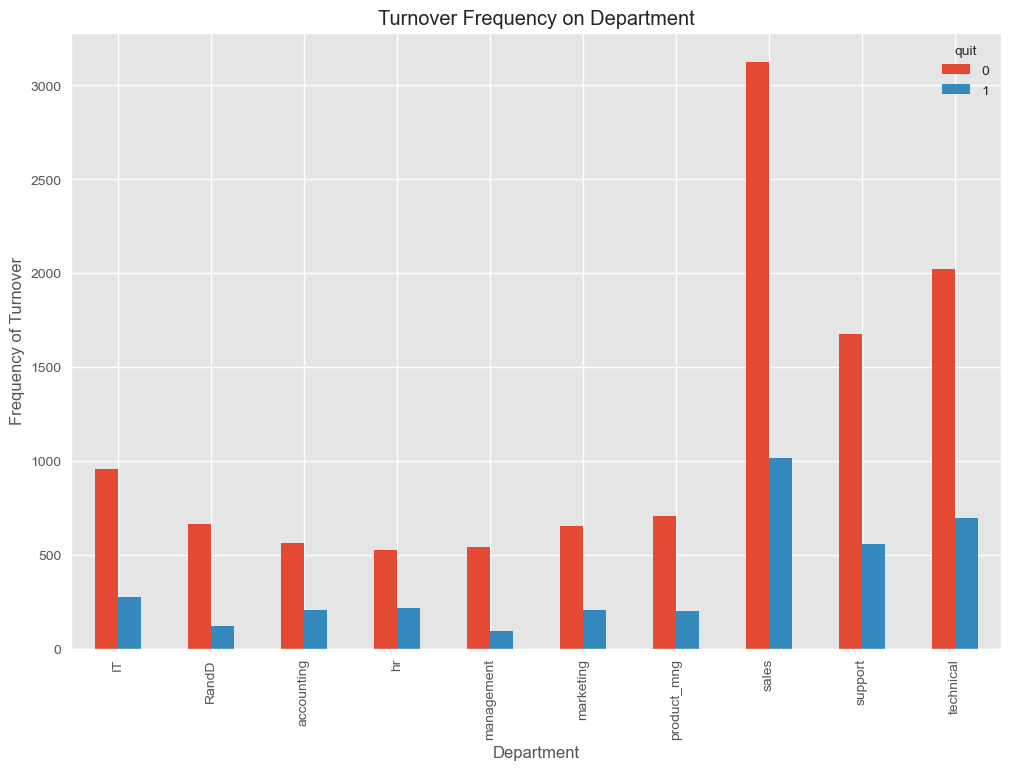

In [104]:
pd.crosstab(hr.department, hr.quit).plot(kind="bar")
plt.title("Turnover Frequency on Department")
plt.xlabel("Department")
plt.ylabel("Frequency of Turnover")
plt.show()

## Encode Categorical Features

In [105]:
cat_vars = ["department","salary"]
for var in cat_vars:
    cat_list = pd.get_dummies(hr[var],prefix=var)
    hr = hr.join(cat_list)

In [106]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,...,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False
1,0.80,0.86,5,262,6,0,1,0,sales,medium,...,False,False,False,False,True,False,False,False,False,True
2,0.11,0.88,7,272,4,0,1,0,sales,medium,...,False,False,False,False,True,False,False,False,False,True
3,0.72,0.87,5,223,5,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False
4,0.37,0.52,2,159,3,0,1,0,sales,low,...,False,False,False,False,True,False,False,False,True,False


In [107]:
hr.drop(columns = ["department","salary"],axis=1,inplace=True)

## Visualize Class Imbalance

In [108]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

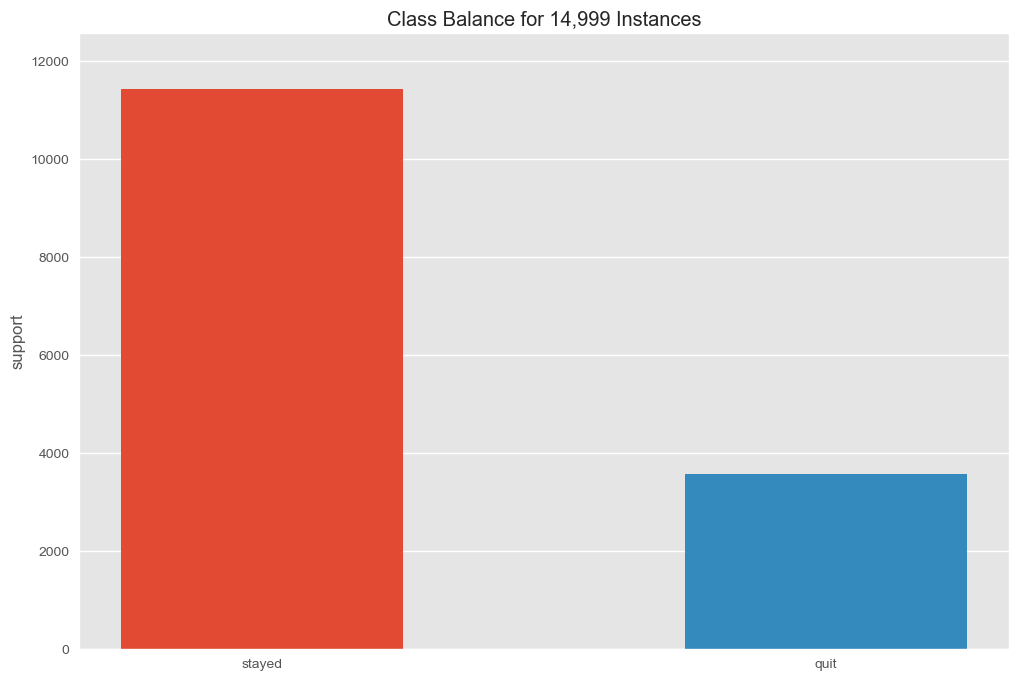

<Axes: title={'center': 'Class Balance for 14,999 Instances'}, ylabel='support'>

In [109]:
visualizer = ClassBalance(labels=["stayed","quit"]).fit(hr.quit)
visualizer.show()

## Create Training and Test Sets

In [110]:
X = hr.loc[:, hr.columns !="quit"]
y=hr.quit

In [111]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,random_state = 0, test_size = 0.2,stratify = y)

## Build an Interactive Decision Tree Classifier

In [112]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [113]:
#import os
#os.environ["PATH"] += os.pathsep + 'C:/Users/vidus/anaconda3/bin'

In [114]:
@interact
def plot_tree(crit=["gini","entropy"],
              split=["best","random"],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=1,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = DecisionTreeClassifier(random_state=0,
                                      criterion=crit,
                                      splitter = split,
                                      max_depth = depth,
                                      min_samples_split = min_split,
                                      min_samples_leaf = min_leaf)
    estimator.fit(X_train,y_train)
    print("Decision Tree Training Accuracy: {:.3f}".format(accuracy_score(y_train,estimator.predict(X_train))))
    print("Decision Tree Test Accuracy: {:.3f}".format(accuracy_score(y_test,estimator.predict(X_test))))
    
    graph = Source(tree.export_graphviz(estimator,out_file=None,
                                       feature_names = X_train.columns,
                                       class_names = ["stayed","quit"],
                                       filled = True))
    display(Image(data=graph.pipe(format="png")))
    return estimator
    
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Build an Interactive Random Forest Classifier

In [115]:
@interact
def plot_tree_rf(crit=["gini","entropy"],
                 bootstrap=[True,False],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state =1,
                                      criterion=crit,
                                      bootstrap=bootstrap,
                                      n_estimators=forests,
                                      max_depth=depth,
                                      min_samples_split=min_split,
                                      min_samples_leaf=min_leaf,
                                      n_jobs=-1,
                                      verbose = False)
    estimator.fit(X_train,y_train)
    print("Random Forests Training Accuracy: {:.3f}".format(accuracy_score(y_train,estimator.predict(X_train))))
    print("Random Forests Test Accuracy: {:.3f}".format(accuracy_score(y_test,estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print("\Visualizing Tree:",0)
    graph = Source(tree.export_graphviz(num_tree,
                                        out_file=None,
                                       feature_names = X_train.columns,
                                       class_names = ["stayed","quit"],
                                       filled = True))
    display(Image(data=graph.pipe(format="png")))
    return estimator
    
    

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

## Feature Importance and Evaluation Metrics

In [116]:
from yellowbrick.model_selection import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")

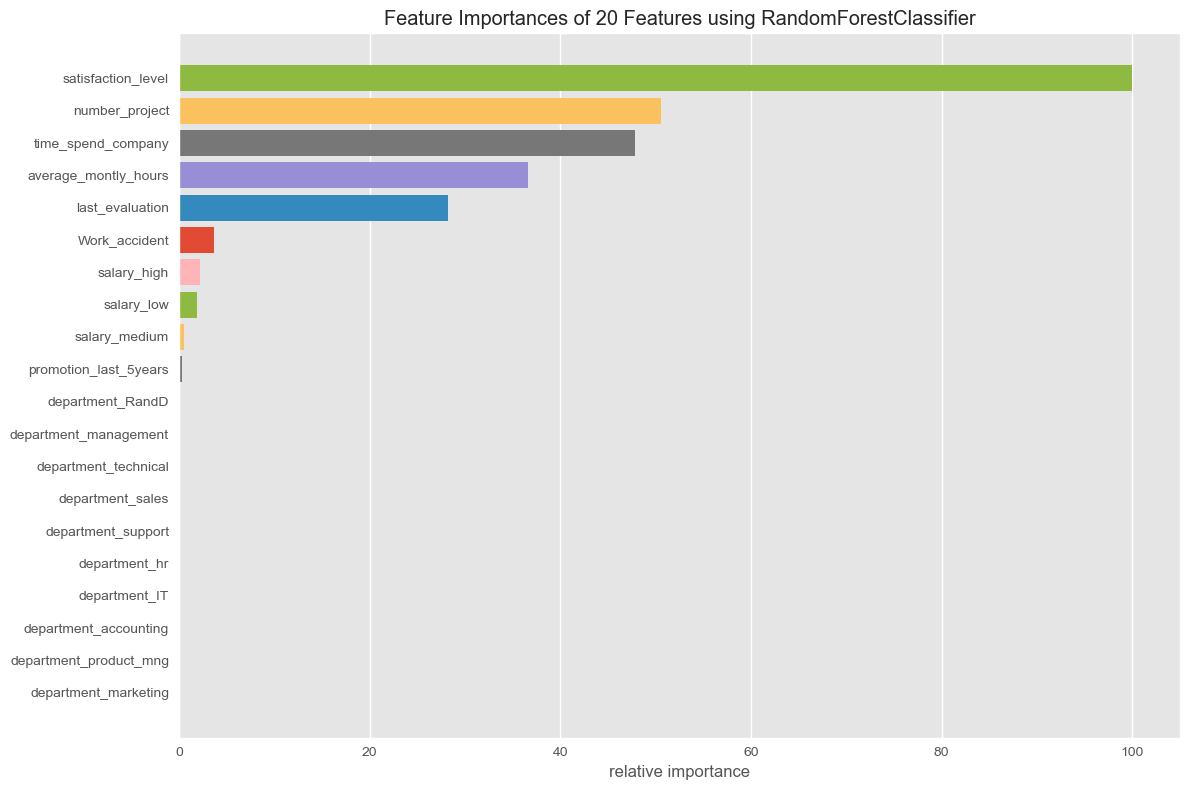

In [117]:
rf = RandomForestClassifier(max_depth=5, 
                            n_jobs=-1, 
                            random_state=1, 
                            verbose=False)
viz = FeatureImportances(rf)
viz.fit(X_train,y_train)
viz.show();

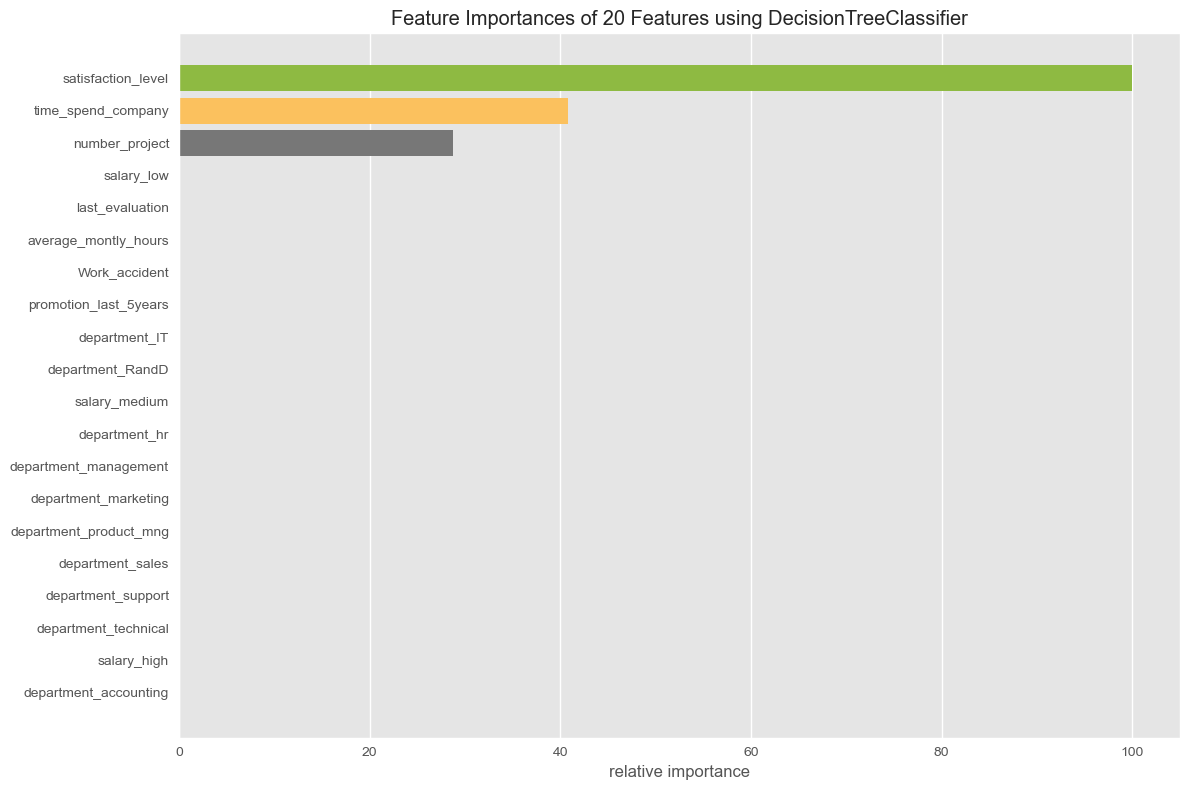

In [118]:
dt = DecisionTreeClassifier(max_depth=2, random_state=0)
viz = FeatureImportances(dt)
viz.fit(X_train,y_train)
viz.show();

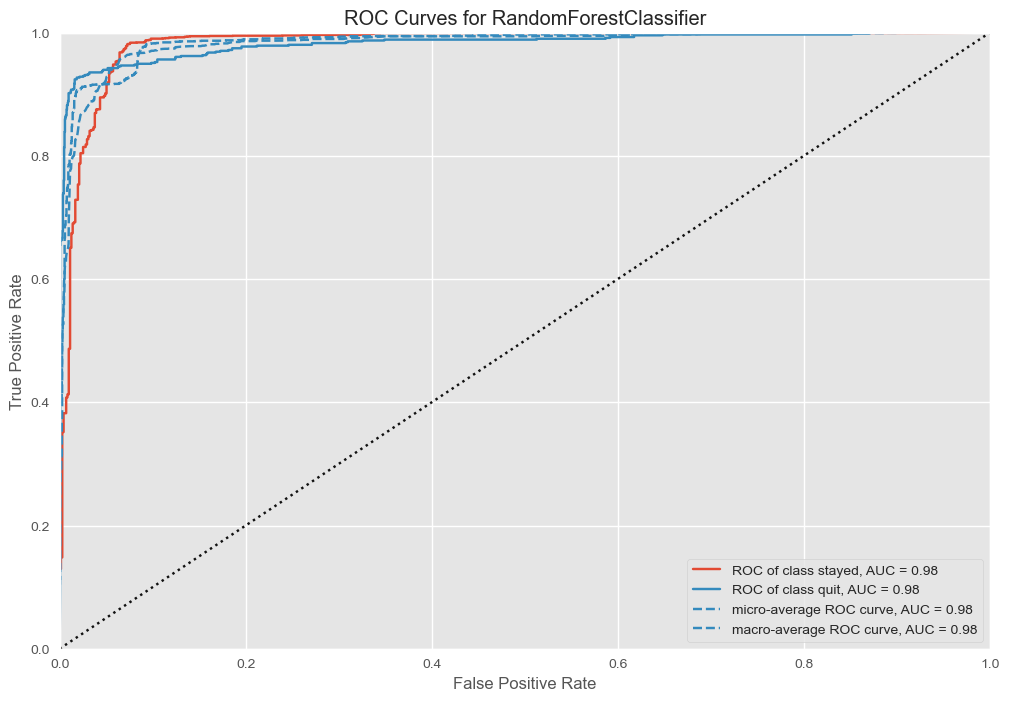

In [119]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(rf, classes = ["stayed","quit"])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();

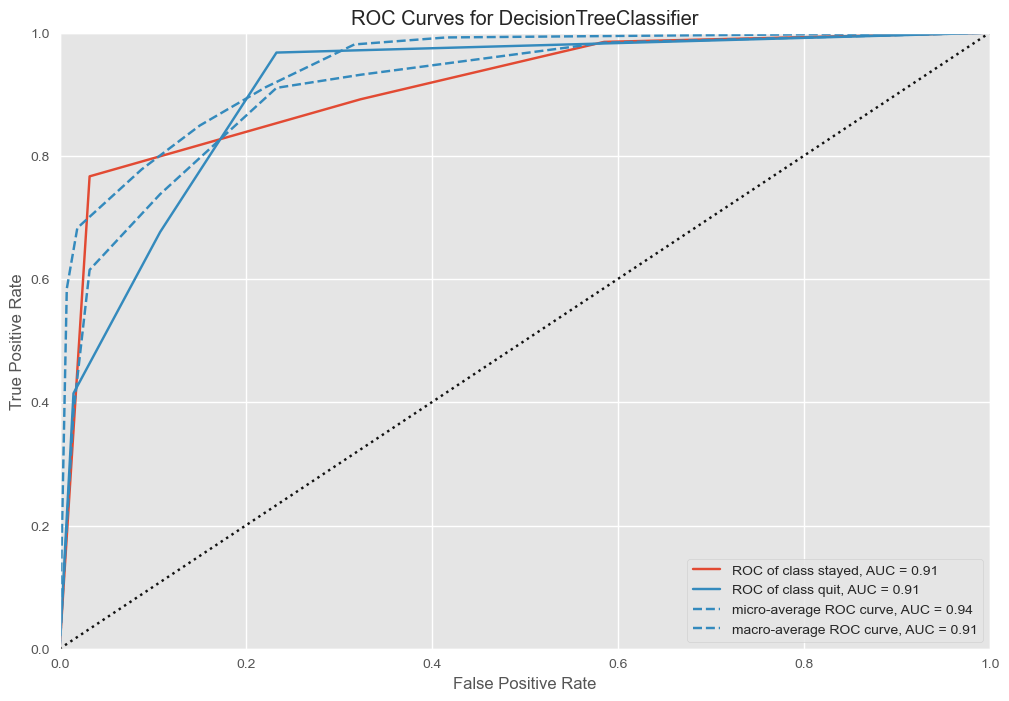

In [120]:
from yellowbrick.classifier import ROCAUC
visualizer = ROCAUC(dt, classes = ["stayed","quit"])
visualizer.fit(X_train,y_train)
visualizer.score(X_test,y_test)
visualizer.poof();